The next thing in my TODO list for this Google Summer of Code season with [NumFOCUS](https://numfocus.org/) is to add new families of models to [Bambi](https://bambinos.github.io/bambi). This is still a WIP but I wanted to show you how to build a robust linear regression model using the `Family` class in Bambi.


In [1]:
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.patches import Rectangle, FancyArrowPatch
from scipy import stats

## What do we mean with robust?

Before showing how to build a robust regression with Bambi we need to be clear about what we mean when we say that a model is robust. Robust to what? How is linear regression non-robust?

In this post, we say a method is robust if its inferences aren't (seriously) affected by the presence of outliers.

## How do outliers affect linear regression?

I think it will be easier to understand how outliers affect linear regressions via an example based on the least squares method. This is not exactly how linear regression works in our Bayesian world, but outlier's bad consequences are similar.

In classic statistics, linear regression models are usually fitted by ordinary least-squares method. This is equivalent to assuming the conditional distribution 
of the response given the predictors is normal (i.e. $y_i|\boldsymbol{X}_i \sim N(\mu_i, \sigma)$) and using the maximum likelihood estimator.

Let's get started by simulating some toy data.

In [2]:
x = np.array([1., 2., 4., 5.])
y = np.array([1.25, 1.45, 4.75, 4.8])

Then, fit a linear regression between and visualize the result. 

The next plot shows the data, the fitted line, and the contribution of each data point to the total (squared) error as a blue square (one way to see the least squares method is as the method that minimizes the sum of the areas of the squares associated to all the points).

In [4]:
b, a = np.polyfit(x, y, 1)
y_hat = a + b * x
residual = y_hat - y

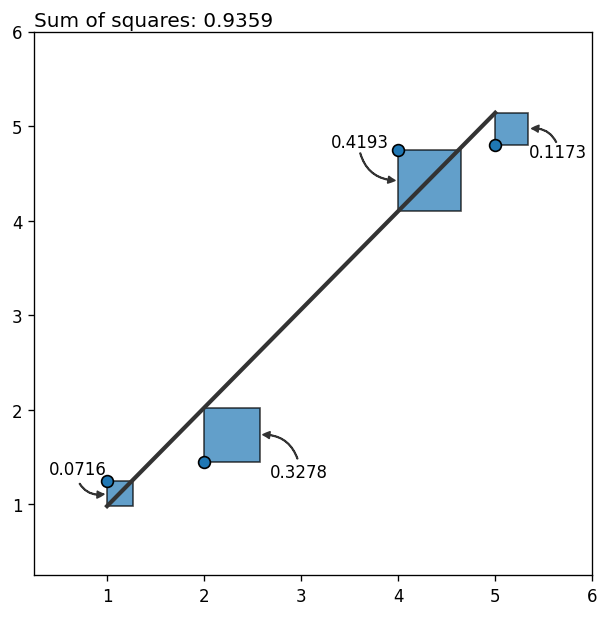

In [5]:
arrowstyle = "Simple, tail_width=0.3, head_width=4, head_length=4"
connectiontyle = "arc3, rad=0.4"
arrowstyles = {"color": "0.2", "arrowstyle": arrowstyle, "connectionstyle": connectiontyle}

fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
fig.set_facecolor("w")
ax.set_xlim(0.25, 6)
ax.set_ylim(0.25, 6)

ax.scatter(x, y, s=50, ec="k")
ax.plot(x, y_hat, color="0.2", lw=2.5)

# Add rectangles
for xy, r in zip(zip(x, y ), residual):
    ax.add_patch(Rectangle(xy, abs(r), r, alpha=0.7, ec="k", zorder=-1, lw=1))

# Add arrows
x_end = x + residual * np.array([0, 1, 0, 1])
x_start = x_end + np.array([-0.3, 0.4, -0.4, 0.3])
y_end = y + residual / 2
y_start = y
y_text = y_end + np.array([0.2, -0.45, 0.35, -0.3])

for xy0, xy1, r, yt in zip(zip(x_start, y_start), zip(x_end, y_end), residual, y_text):
    ax.add_patch(FancyArrowPatch(xy0, xy1, **arrowstyles))
    ax.text(xy0[0], yt, str(round(abs(r ** 2), 4)), ha="center")

ax.text(
    0, 1.01, f"Sum of squares: {round(np.sum(residual ** 2), 4)}", 
    size=12, transform=ax.transAxes, va="baseline"
);

So far so good! It looks like the fitted line is a good representation of the relationship between the variables. 

What happens if we introduce an outlier? In other words, what happens if there's a new point that deviates too much from the pattern we've just seen above? Let's see it!

In [6]:
x = np.insert(x, 2, 2.25)
y = np.insert(y, 2, 5.8)

In [7]:
b, a = np.polyfit(x, y, 1)
y_hat = a + b * x
residual = y_hat - y

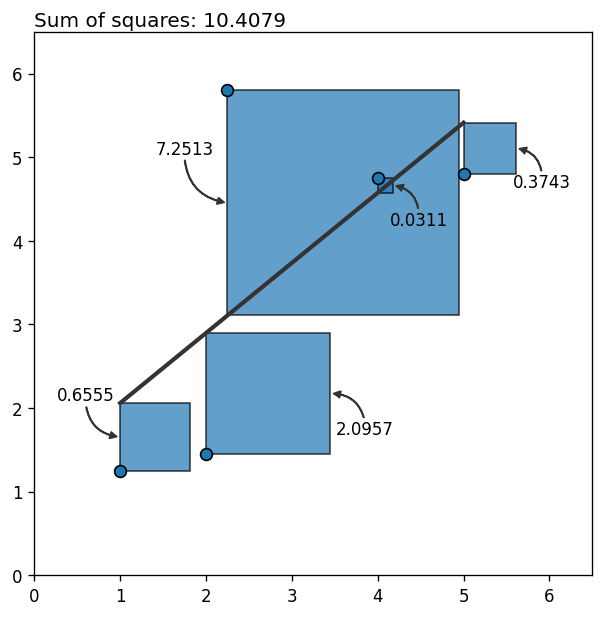

In [8]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
fig.set_facecolor("w")
ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)

ax.scatter(x, y, s=50, ec="k")
ax.plot(x, y_hat, color="0.2", lw=2.5)

# Add rectangles
for xy, r in zip(zip(x, y ), residual):
    ax.add_patch(Rectangle(xy, abs(r), r, alpha=0.7, ec="k", zorder=-1, lw=1))

# Add arrows
x_end = x + np.abs(residual) * np.array([0, 1, 0, 1, 1])
x_start = x_end + np.array([-0.4, 0.4, -0.5, 0.3, 0.3])
y_end = y + residual / 2
y_start = y + np.array([0.8, 0.4, -0.8, -0.4, 0])
y_text = y_start + np.array([0.1, -0.1, 0.1, -0.1, -0.1])

for xy0, xy1, r, yt in zip(zip(x_start, y_start), zip(x_end, y_end), residual, y_text):
    ax.add_patch(FancyArrowPatch(xy0, xy1, **arrowstyles))
    ax.text(xy0[0], yt, str(round(abs(r ** 2), 4)), ha="center", va="center")

ax.text(
    0, 1.01, f"Sum of squares: {round(np.sum(residual ** 2), 4)}", 
    size=12, transform=ax.transAxes, va="baseline"
);

What a bummer! Why do we have such a huge error? It's 10 times the previous error with only one extra data point! Why?!

It happens that each point's contribution to the error grows quadratically as it moves away from the rest. Outliers not only contribute **a lot** to the total error,
they also bias the estimation towards themselves, increasing the error associated with other points too. The final result? the fitted line is not a faithful representation of the relationship between the variables.

## Linear regression in a Bayesian way

Now that we've seen how bad outliers can be above, let's see how one can robust a Bayesian linear regression. This part of the post is based on the [Robust Linear Regression](https://docs.pymc.io/pymc-examples/examples/generalized_linear_models/GLM-robust.html) in PyMC3 docs.

Here, we simulate data suitable for a normal linear regression and contaminate it with a few outliers.

In [9]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
true_regression_line = true_intercept + true_slope * x
y = true_regression_line + np.random.normal(scale=0.5, size=size)

x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])

data = pd.DataFrame(dict(x = x_out, y = y_out))

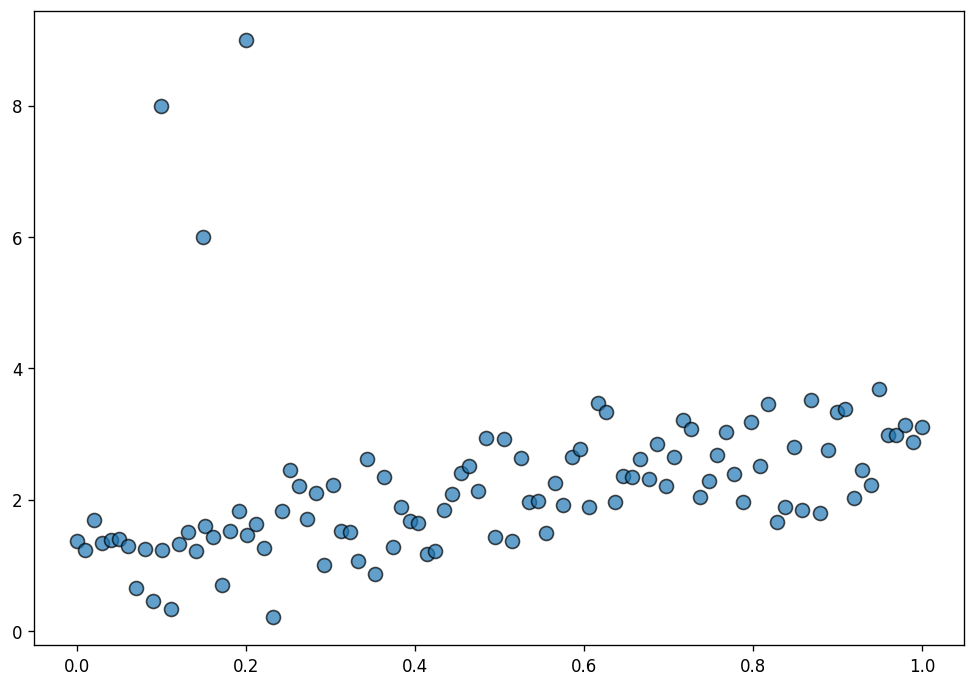

In [10]:
fig, ax = plt.subplots(figsize=(10, 7), dpi=120)
fig.set_facecolor("w")

ax.scatter(data["x"], data["y"], s=70, ec="black", alpha=0.7);

### Normal linear regression

The normal linear regression is as follows

$$
y_i \sim \text{Normal}(\mu_i, \sigma)
$$

where $\mu_i = \beta_0 + \beta_1 x_i$, and the priors are of the form

$$
\begin{array}{c}
\beta_0 \sim \text{Normal} \\
\beta_1 \sim \text{Normal}  \\
\sigma \sim \text{HalfStudentT}
\end{array}
$$

with their parameters automatically set by Bambi.

In [11]:
model = bmb.Model("y ~ x", data=data)
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_sigma, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


To evaluate the fit, we use the posterior predictive regression lines. The line in black is the true regression line.

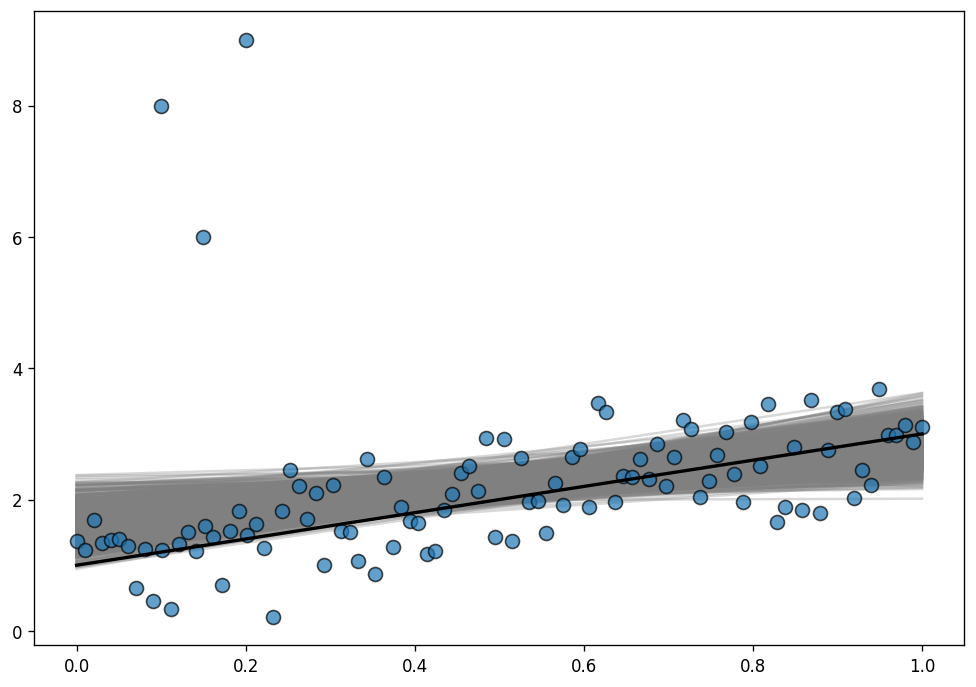

In [12]:
# Prepare data
x = np.linspace(0, 1, num=200)
posterior_stacked = idata.posterior.stack(samples=("chain", "draw"))
intercepts = posterior_stacked["Intercept"].values
slopes = posterior_stacked["x"].values

# Create plot
fig, ax = plt.subplots(figsize=(10, 7), dpi=120)

# Data points
ax.scatter(data["x"], data["y"], s=70, ec="black", alpha=0.7)

# Posterior regression lines
for a, b in zip(intercepts, slopes):
    ax.plot(x, a + b * x, color ="0.5", alpha=0.3, zorder=-1)

# True regression line
ax.plot(x, true_intercept + true_slope * x, color="k", lw=2);

As you can see, the posterior distribution fo the regression lines is not centered around the true regression line, which means the estimations are **highly biased**. This is the same phenomena we saw above with the least-squares toy example.

Why does it happen here? The reason is that the normal distribution does not have a lot of mass in the tails and consequently, an outlier will affect the fit strongly. 

Since the problem is the light tails of the Normal distribution we can instead assume that our data is not normally distributed but instead distributed according to the Student T distribution which has heavier tails as shown next.

### Normal and Student-T distributions

Here we plot the pdf of a standard normal distribution and the pdf of a student-t distribution with 3 degrees of freedom.

In [13]:
x = np.linspace(-8, 8, num=400)
y_normal = stats.norm.pdf(x)
y_t = stats.t.pdf(x, df = 3)

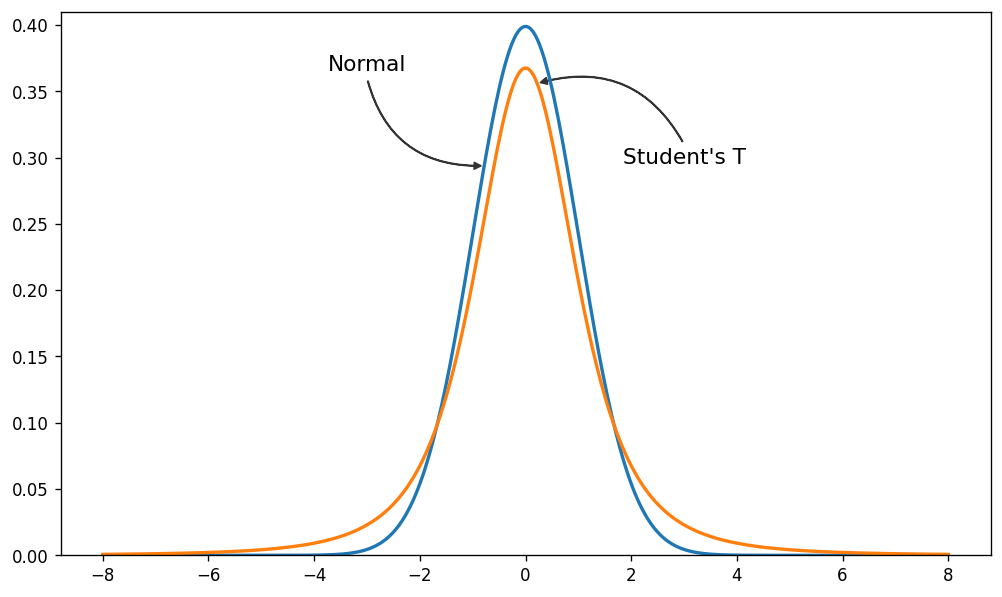

In [14]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)
fig.set_facecolor("w")
ax.set_ylim(0, 0.41)

ax.plot(x, y_normal, lw=2)
ax.plot(x, y_t, lw=2)

ax.add_patch(FancyArrowPatch((-3, 0.36), (x[180], y_normal[180]), **arrowstyles, zorder=1))
ax.add_patch(FancyArrowPatch((3, 0.31), (x[205], y_t[205]), **arrowstyles, zorder=1))

ax.text(-3, 0.37, "Normal", size=13, ha="center", va="center")
ax.text(3, 0.30, "Student's T", size=13, ha="center", va="center");

As you can see, the probability of values far away from the mean are much more likely under the Student-T distribution than under the Normal distribution. 

### Robust linear regression

The difference with the model above is that this one uses a StudentT likelihood instead of a Normal one. 

Bambi does not support yet to use the student-t distribution as the likelihood function for linear regression. However, we can construct our own custom family and Bambi will understand how to work with it.

Custom families are represented by the [Family](https://bambinos.github.io/bambi/main/api_reference.html#bambi.families.Family) class in Bambi. Let's see what we need to create a custom family.

First of all, we need a name. In this case the name is going to be just `"t"`. Second, there is the `likelihood` function. This is represented by an object of class `Likelihood` in Bambi. To define a likelihood function we need the following:

* The name of the distribution in PyMC3. In this case, it is `"StudentT"`.
* The name of the parent parameter (the mean). It is `"mu"`.
* The prior distributions for the auxiliary parameters in the distribution. 
These are `nu` and `sigma` in the StudentT distribution.

Finally, we pass the link function. This can be a string or an object of class `Link`. In this case it's simply the identity function, which can be passed as a string.


In [15]:
# Construct likelihood
nu = bmb.Prior("Gamma", alpha=3, beta=1)
sigma = bmb.Prior("HalfStudentT", nu=4, sigma=1)
likelihood = bmb.Likelihood(name="StudentT", parent="mu", sigma=sigma, nu=nu)

# Construct family
t_family = bmb.Family(name = "t", likelihood = likelihood, link = "identity")

# In addition, we pass our custom priors for the terms in the model.
priors = {
  "Intercept": bmb.Prior("Normal", mu=2, sigma=5),
  "x": bmb.Prior("Normal", mu=0, sigma=10)
}

# Just add the `prior` and `family` arguments
model = bmb.Model("y ~ x", data, priors=priors, family=t_family)
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_nu, y_sigma, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


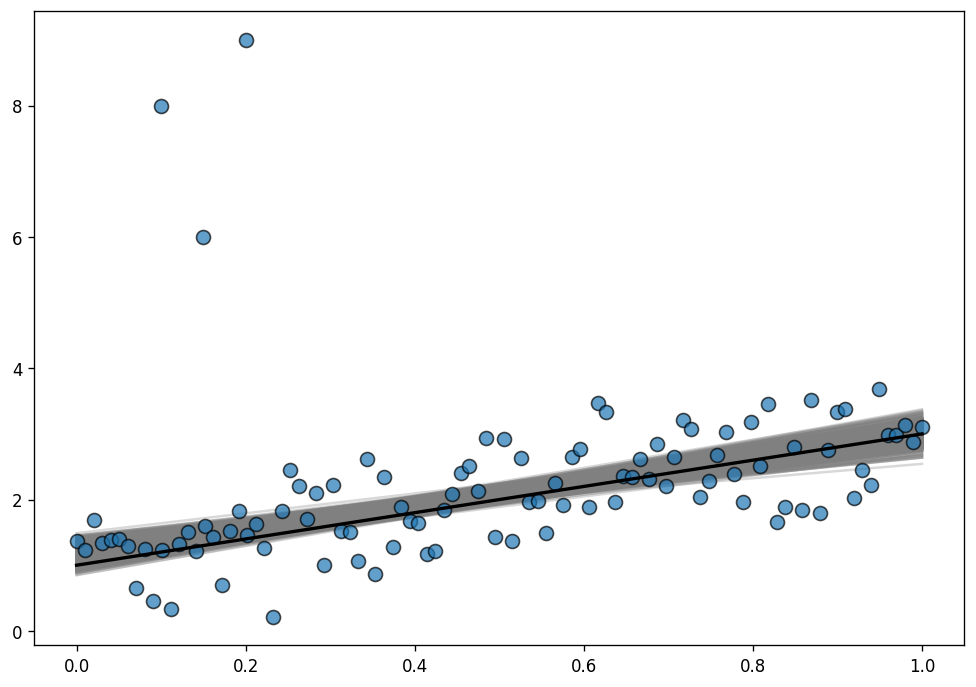

In [16]:
# Prepare data
x = np.linspace(0, 1, num=200)
posterior_stacked = idata.posterior.stack(samples=("chain", "draw"))
intercepts = posterior_stacked["Intercept"].values
slopes = posterior_stacked["x"].values

# Create plot
fig, ax = plt.subplots(figsize=(10, 7), dpi=120)

# Data points
ax.scatter(data["x"], data["y"], s=70, ec="black", alpha=0.7)

# Posterior regression lines
for a, b in zip(intercepts, slopes):
    ax.plot(x, a + b * x, color ="0.5", alpha=0.3, zorder=-1)

# True regression line
ax.plot(x, true_intercept + true_slope * x, color="k", lw=2);

Much better now! The posterior distribution of the regression lines is almost centered around the true regression line, and uncertainty has decreased, that's great! The outliers are barely influencing our estimation because our likelihood function assumes that outliers are much more probable than under the Normal distribution.